In [70]:
import torch
import os
import pandas as pd
import numpy as np

In [71]:
df = pd.read_csv('/content/AQI.csv')
df.drop('Unnamed: 0',axis=1, inplace=True)

In [72]:
df.columns

Index(['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'AQI_calculated'], dtype='object')

In [74]:
df.index = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.drop('date',axis=1,inplace=True)

In [75]:
df.head()

,pm25,pm10,o3,no2,so2,co,AQI_calculated
date,,,,,,,
2020-06-01,0.137387,0.055394,0.018624,0.082315,0.696354,0.050939,0.280453
2020-06-02,0.141118,0.072870,0.023941,0.064412,0.786002,0.050939,0.288952
2020-06-03,0.187495,0.091095,0.014350,0.064853,0.704045,0.050939,0.416431
2020-06-04,0.216831,0.084656,0.012625,0.070164,0.650707,0.050939,0.495751
2020-06-05,0.207105,0.092126,0.014179,0.064640,0.553987,0.035197,0.467422


<Axes: xlabel='date'>

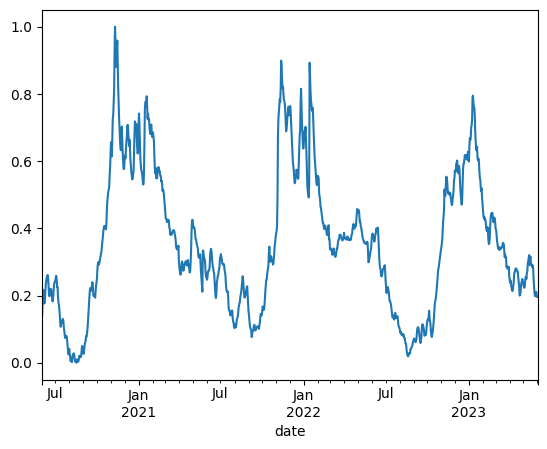

In [76]:
temp = df['pm25']
temp.plot()

In [77]:
time_shift = 7

target_data = df['AQI_calculated'].shift(time_shift)
data = df.iloc[:-time_shift]
data

,pm25,pm10,o3,no2,so2,co,AQI_calculated
date,,,,,,,
2020-06-01,0.137387,0.055394,0.018624,0.082315,0.696354,0.050939,0.280453
2020-06-02,0.141118,0.072870,0.023941,0.064412,0.786002,0.050939,0.288952
2020-06-03,0.187495,0.091095,0.014350,0.064853,0.704045,0.050939,0.416431
2020-06-04,0.216831,0.084656,0.012625,0.070164,0.650707,0.050939,0.495751
2020-06-05,0.207105,0.092126,0.014179,0.064640,0.553987,0.035197,0.467422
...,...,...,...,...,...,...,...
2023-05-22,0.289764,0.371980,0.387550,0.480245,0.038509,0.288700,0.555241
2023-05-23,0.277718,0.335230,0.362967,0.452577,0.025983,0.281535,0.549575
2023-05-24,0.245549,0.314992,0.373755,0.437160,0.025931,0.275298,0.529745


In [78]:
test_head = data.index[int(0.8*len(data))]
test_head

Timestamp('2022-10-21 00:00:00')

In [79]:
df_train = df.loc[:test_head,:]
df_test = df.loc[test_head:,:]
target_train = target_data.loc[:test_head]
target_test = target_data.loc[test_head:]

In [80]:
cols_means = {}
for col in df.columns:
    cols_means[col] = df_train[col].mean()
    df_train[col] = df_train[col].fillna(value=cols_means[col])
    df_test[col] = df_test[col].fillna(value=cols_means[col])

In [81]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]


In [83]:
i = 27
sequence_length = 7
features = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
target = 'AQI_calculated'

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)


tensor([[0.2180, 0.0789, 0.0226, 0.0117, 0.3725, 0.0321],
        [0.2010, 0.0831, 0.0180, 0.0099, 0.3426, 0.0347],
        [0.1920, 0.0784, 0.0154, 0.0084, 0.3226, 0.0369],
        [0.1824, 0.0816, 0.0132, 0.0071, 0.3613, 0.0387],
        [0.1903, 0.0946, 0.0113, 0.0060, 0.3166, 0.0323],
        [0.2074, 0.1159, 0.0096, 0.0028, 0.3336, 0.0267],
        [0.2313, 0.1227, 0.0095, 0.0000, 0.3040, 0.0219]])


In [84]:
from torch.utils.data import DataLoader
torch.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)


torch.Size([3, 7, 6])
tensor([[[0.3768, 0.3227, 0.2851, 0.3184, 0.2270, 0.6475],
         [0.3743, 0.3248, 0.2841, 0.3139, 0.2389, 0.6411],
         [0.3666, 0.3290, 0.2922, 0.3099, 0.2494, 0.6355],
         [0.3667, 0.3321, 0.2903, 0.3325, 0.2530, 0.6386],
         [0.3642, 0.3443, 0.2731, 0.3522, 0.2670, 0.6570],
         [0.3687, 0.3563, 0.2891, 0.3693, 0.2738, 0.6730],
         [0.3713, 0.3827, 0.2953, 0.3994, 0.2905, 0.6712]],

        [[0.2724, 0.2641, 0.1546, 0.4401, 0.1560, 0.2533],
         [0.2974, 0.2837, 0.1576, 0.4480, 0.1608, 0.2823],
         [0.3328, 0.2974, 0.1576, 0.4484, 0.1650, 0.2917],
         [0.3871, 0.3428, 0.1616, 0.4465, 0.1632, 0.2841],
         [0.4222, 0.3635, 0.1585, 0.4492, 0.1617, 0.2854],
         [0.4255, 0.3617, 0.1636, 0.4494, 0.1604, 0.2787],
         [0.4158, 0.3483, 0.1590, 0.4474, 0.1538, 0.2728]],

        [[0.7503, 0.4341, 0.0169, 0.4495, 0.1202, 0.5860],
         [0.7586, 0.4415, 0.0391, 0.4605, 0.1188, 0.5954],
         [0.7586, 0.4188, 0.03

In [85]:
batch_size = 4
sequence_length = 7

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 7, 6])
Target shape: torch.Size([4])


In [86]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out


In [87]:
learning_rate = 5e-4
num_hidden_units = 8

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [88]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(30):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()


Untrained test
--------
Test loss: 0.20801612499513125

Epoch 0
---------
Train loss: 0.06965512699515614
Test loss: 0.011068933308961916

Epoch 1
---------
Train loss: 0.01489273550682042
Test loss: 0.007598915089099472

Epoch 2
---------
Train loss: 0.009798487738204364
Test loss: 0.0017559275198245335

Epoch 3
---------
Train loss: 0.005602060373847003
Test loss: 0.0007339887482039717

Epoch 4
---------
Train loss: 0.0028603101694001177
Test loss: 0.0007831347756380861

Epoch 5
---------
Train loss: 0.001870294215194041
Test loss: 0.0019535381763425745

Epoch 6
---------
Train loss: 0.0015540944105066033
Test loss: 0.0016206192563243491

Epoch 7
---------
Train loss: 0.0014566761624108821
Test loss: 0.0015015767336368107

Epoch 8
---------
Train loss: 0.001299639897376217
Test loss: 0.0015608259043945413

Epoch 9
---------
Train loss: 0.0012435900008151218
Test loss: 0.0015424456671194332

Epoch 10
---------
Train loss: 0.0011670195592448501
Test loss: 0.0014412419197405893

Epoch 1

In [89]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

# for c in df_out.columns:
#     df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)


            AQI_calculated  Model forecast
date                                      
2020-06-01        0.280453        0.353226
2020-06-02        0.288952        0.363128
2020-06-03        0.416431        0.392813
2020-06-04        0.495751        0.430290
2020-06-05        0.467422        0.453238
...                    ...             ...
2023-05-29        0.475921        0.448910
2023-05-30        0.478754        0.441304
2023-05-31        0.439093        0.429294
2023-06-01        0.444759        0.419725
2023-06-02        0.441926        0.409390

[1098 rows x 2 columns]


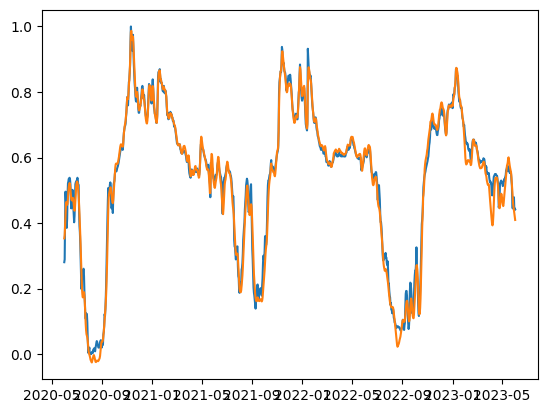

In [91]:
import matplotlib.pyplot as plt
plt.plot(df_out['AQI_calculated'])
plt.plot(df_out['Model forecast'])
plt.show()